In [ ]:
# 必要なライブラリをインストール
!pip install japanize_matplotlib
!pip install pmdarima

In [22]:
# ライブラリを起動
from dateutil.relativedelta import relativedelta
import japanize_matplotlib
import math as math
import numpy as np
import pandas as pd
import scipy as sp
import random
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# (1) 時系列モデルによる政策評価

## (1-1) AR(1)モデルのインパルス応答関数

AR(1)モデルにおいて、自己回帰係数を$\phi=0.1$、$\phi=0.7$、$\phi=0.95$とした場合の結果をプロットすると、以下のとおり（図1.1を作成できる）。

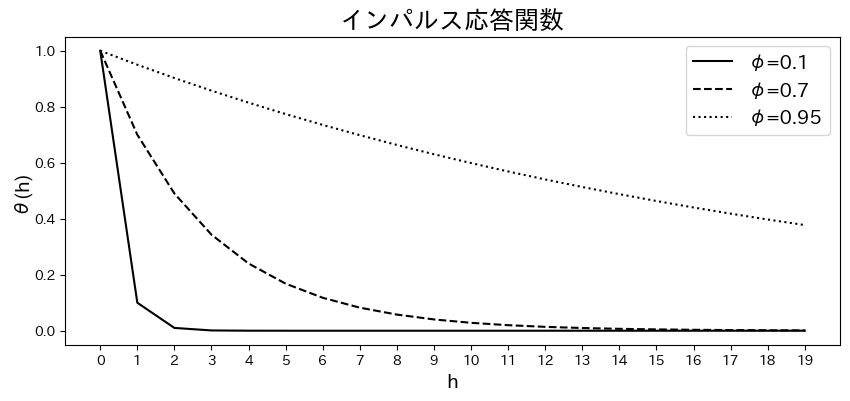

In [ ]:
# AR(1)モデルのインパルス応答関数
PERIOD = 20
PHI = [0.1, 0.7, 0.95]
output = np.zeros([len(PHI), PERIOD])
for i in range(0, len(PHI), 1):
    for j in range(0, PERIOD, 1):
        output[i, j] = 1 * PHI[i] ** j

# グラフの描画
plt.figure(figsize=(10,4))
plt.plot(output[0,:], color='black', label='φ=0.1')
plt.plot(output[1,:], color='black', linestyle='dashed', label='φ=0.7')
plt.plot(output[2,:], color='black', linestyle='dotted', label='φ=0.95')
plt.title('インパルス応答関数', fontsize=18)
plt.xticks(np.arange(0, PERIOD, 1))
plt.xlabel('h', fontsize=14)
plt.ylabel('θ(h)', fontsize=14)
plt.legend(loc='upper right', fontsize=14)

## (1-2) GDPギャップ（日本銀行が推計している需給ギャップ）を用いたARモデルの推定

GDPギャップ（日本銀行が推計している需給ギャップ）をプロットすると、以下のとおり（図1.2を作成できる）。

*   期間は1983年第1四半期から2023年第4四半期まで


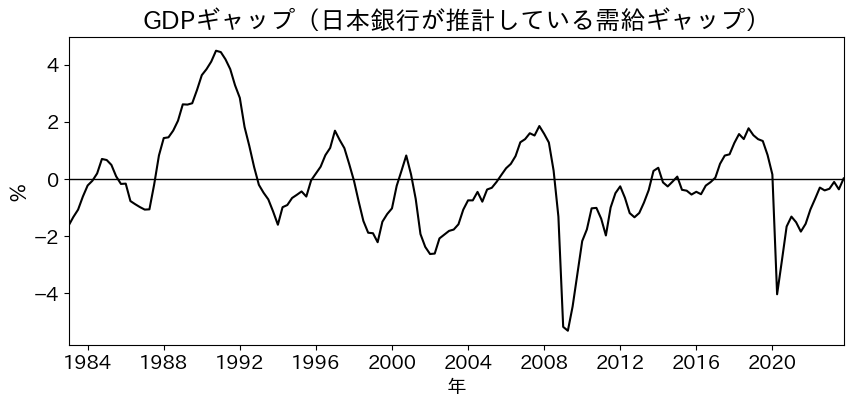

In [26]:
# データの読み込みと図示
dinput = pd.read_excel('/content/drive/My Drive/Data/data_VAR1.xlsx',
                       sheet_name='data_q', header=[0])
data = np.zeros([len(dinput), 1])
for i in range(1, len(dinput)):
    data[:, 0] = dinput.gapboj
data = pd.DataFrame(data[12:])
dlen = len(data)
dti = pd.date_range("1983-01-01", periods=dlen, freq="QS")

plt.figure(figsize=(10,4))
plt.plot(dti, data, color='black')
plt.hlines([0], ['1983-01-01'], ['2023-10-01'], color='black', linewidth=1)
plt.title('GDPギャップ（日本銀行が推計している需給ギャップ）', fontsize=18)
plt.xlabel('年', fontsize=14, loc='center')
plt.xlim(dti[0], dti[-1])
plt.ylabel('％', fontsize=14)
plt.tick_params(labelsize=14)

ここで、このGDPギャップに対して、AR(1)モデルとAR(2)モデルを推定し、それぞれについてインパルス応答関数をプロットすると、以下のとおり（図1.3を作成できる）。

*   ショックのサイズは各ARモデルの誤差項の$1$標準偏差とする（AR(1)モデルでは$0.637$、AR(2)モデルでは$0.580$）
*   推定された結果、インパルス応答関数は、AR(1)モデルは単調減少になる一方、AR(2)モデルはこぶ型となる
*   AR(1)モデルで推定されたパラメーターは、1期ラグが$0.924$
*   AR(2)モデルで推定されたパラメーターは、1期ラグが$1.305$、2期ラグが$-0.411$となり、Blanchard(1981)の結果（1期ラグが$1.34$、2期ラグが$-0.42$）と近い

AR(1)モデルの誤差項の標準偏差 
 [0.63651285]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     952.9
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           2.78e-69
Time:                        12:31:24   Log-Likelihood:                -156.68
No. Observations:                 162   AIC:                             317.4
Df Residuals:                     160   BIC:                             323.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.00

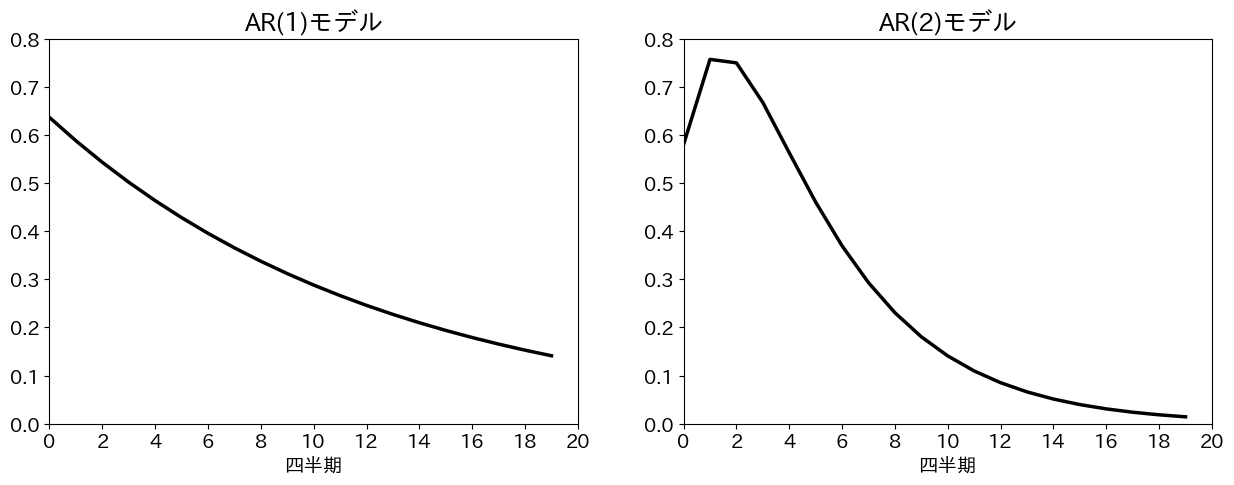

In [ ]:
# ARモデルの推定とインパルス応答関数
L = 2
MAX_H = 20
ssize = len(data)
plt.figure(figsize=(15, 5))
predict_result = np.zeros(MAX_H)
for l in range(1, L+1, 1):
    train_x, train_y = pd.DataFrame(), pd.DataFrame(data[L : ssize])
    for ll in range(1, l + 1):
        train_x_lagged = pd.DataFrame(
            data[L - ll : L - ll + len(train_y)].to_numpy()
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
    model = LinearRegression()
    model.fit(train_x, train_y)
    y_hat = model.predict(train_x)
    resid = np.std(y_hat - train_y)
    predict_result[0] = resid
    test_x = pd.DataFrame(pd.concat([resid,
                                     pd.DataFrame([np.zeros(l)])],
                                    axis=1).to_numpy())
    test_x = test_x.iloc[:,:l]
    for h in range(1, MAX_H, 1):
        forecast = pd.DataFrame([np.sum((test_x * model.coef_).to_numpy())])
        test_x = pd.concat([forecast,
                            pd.DataFrame((test_x.T[:-1]).T.to_numpy())],
                           axis=1)
        predict_result[h] = np.squeeze(np.array(forecast))
    ar_impulse = pd.DataFrame(predict_result).to_numpy()
    param_y = train_y
    param_x = sm.add_constant(train_x)
    param_model = sm.OLS(param_y.to_numpy(), param_x.to_numpy())
    param_result = param_model.fit()
    print('AR(%i)モデルの誤差項の標準偏差 \n' %l, resid.to_numpy())
    print(param_result.summary())
    # グラフの描画
    plt.subplot(1, 2, l)
    plt.plot(ar_impulse, linestyle='solid', color='black', linewidth=2.5)
    plt.title('AR(%i)モデル' %l, fontsize=18)
    plt.xlabel('四半期', fontsize=14)
    plt.tick_params(labelsize=14)
    plt.xticks(np.arange(0, MAX_H + 1, 2))
    plt.xlim(0, MAX_H)
    plt.ylim(0, 0.8)

## (1-3)AIC、BICによるラグ次数の選択

ARモデルのラグ次数を選択するにあたり、最大ラグ次数を4としてAICとBICを計算すると、いずれの場合でもラグ次数は2が選択される

In [ ]:
# ARモデルのラグ次数の選択
def get_aic_bic(gap, y, y_hat, param1, param2):
    sse = ((y - y_hat) ** 2).sum(axis=0)
    aic = math.log(sse / (len(gap) - param1)) + (l + 1) * 2 / (len(gap) - param2)
    bic = math.log(sse / (len(gap) - param1)) + (l + 1) * math.log(
        (len(gap) - param2)
    ) / (len(gap) - param2)
    return aic, bic


MAX_L = 4
aic_result, bic_result = np.zeros([MAX_L + 1, 3]), np.zeros([MAX_L + 1, 3])
# AR(0)モデルの場合
l = 0
# AIC・BICの計算方法1:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合
y = pd.DataFrame(data[MAX_L:])
aic_result[l, 0], bic_result[l, 0] = get_aic_bic(data, y, np.mean(y.to_numpy()),
                                                 MAX_L, MAX_L)
# AIC・BICの計算方法2:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合（標本分散の自由度を調整）
y = pd.DataFrame(data[MAX_L:])
aic_result[l, 1], bic_result[l, 1] = get_aic_bic(
    data, y, np.mean(y.to_numpy()), MAX_L + l + 1, MAX_L
)
# AIC・BICの計算方法3:それぞれのARモデルで利用できる観測値をすべて利用した場合
y = pd.DataFrame(data[l:])
aic_result[l, 2], bic_result[l, 2] = get_aic_bic(data, y, np.mean(y.to_numpy()),
                                                 l, l)

# AR(p)モデル（p>0）の場合
for l in range(1, MAX_L + 1):
    # AIC・BICの計算方法1:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合
    x, y = pd.DataFrame(), pd.DataFrame(data[MAX_L:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(data[MAX_L - ll : MAX_L - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 0], bic_result[l, 0] = get_aic_bic(data, y, model.predict(x),
                                                     MAX_L, MAX_L)

    # AIC・BICの計算方法2:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合（誤差項の標本分散の自由度を調整）
    x, y = pd.DataFrame(), pd.DataFrame(data[MAX_L:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(data[MAX_L - ll : MAX_L - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 1], bic_result[l, 1] = get_aic_bic(
        data, y, model.predict(x), MAX_L + l + 1, MAX_L
    )

    # AIC・BICの計算方法3:それぞれのARモデルで利用できる観測値をすべて利用した場合
    x, y = pd.DataFrame(), pd.DataFrame(data[l:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(data[l - ll : l - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 2], bic_result[l, 2] = get_aic_bic(data, y, model.predict(x),
                                                     l, l)

# 結果表の作成
df_aic_result = pd.DataFrame(
    aic_result,
    columns=[f'方法{i+1}' for i in range(3)],
    index=[f'L={i}' for i in range(MAX_L + 1)],
)
df_bic_result = pd.DataFrame(
    bic_result,
    columns=[f'方法{i+1}' for i in range(3)],
    index=[f'L={i}' for i in range(MAX_L + 1)],
)
print('[AIC]\n', df_aic_result)
print('[BIC]\n', df_bic_result)
print('[best AIC lag length]\n', df_aic_result.idxmin())
print('[best BIC lag length]\n', df_bic_result.idxmin())

[AIC]
           方法1       方法2       方法3
L=0  1.058268  1.064537  1.044374
L=1 -0.868643 -0.856064 -0.884661
L=2 -1.040606 -1.021678 -1.052386
L=3 -1.032700 -1.007382 -1.038315
L=4 -1.020482 -0.988733 -1.020482
[BIC]
           方法1       方法2       方法3
L=0  1.077487  1.083757  1.063275
L=1 -0.830203 -0.817625 -0.846701
L=2 -0.982946 -0.964018 -0.995208
L=3 -0.955820 -0.930502 -0.961758
L=4 -0.924383 -0.892634 -0.924383
[best AIC lag length]
 方法1    L=2
方法2    L=2
方法3    L=2
dtype: object
[best BIC lag length]
 方法1    L=2
方法2    L=2
方法3    L=2
dtype: object


## (練習問題2) GDPギャップ（内閣府推計値）を用いたARモデルの推定

GDPギャップ（内閣府推計）をプロットすると、以下のとおり。

*   期間は1980年第1四半期から2023年第4四半期まで


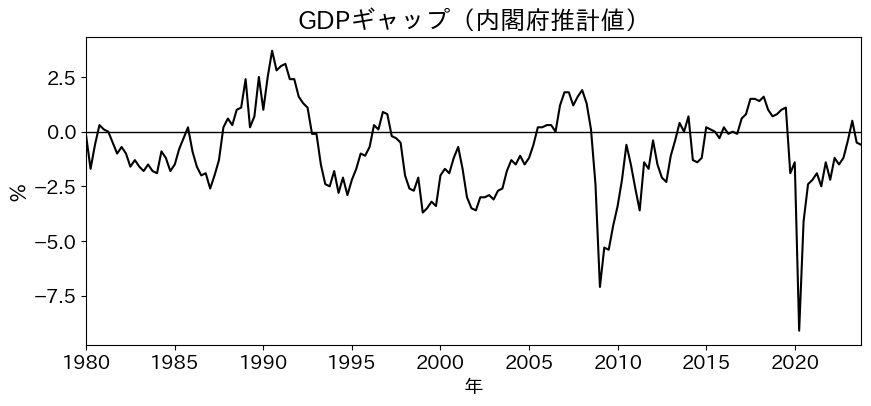

In [28]:
# データの読み込みと図示
dinput = pd.read_excel('/content/drive/My Drive/Data/data_VAR1.xlsx',
                       sheet_name='data_q', header=[0])
data = np.zeros([len(dinput), 1])
for i in range(1, len(dinput)):
    data[:, 0] = dinput.gapcao
data = pd.DataFrame(data[0:])
dlen = len(data)
dti = pd.date_range("1980-01-01", periods=dlen, freq="QS")

plt.figure(figsize=(10,4))
plt.plot(dti, data, color='black')
plt.hlines([0], ['1980-01-01'], ['2023-10-01'], color='black', linewidth=1)
plt.title('GDPギャップ（内閣府推計値）', fontsize=18)
plt.xlabel('年', fontsize=14, loc='center')
plt.xlim(dti[0], dti[-1])
plt.ylabel('％', fontsize=14)
plt.tick_params(labelsize=14)

ここで、このGDPギャップに対して、AR(1)モデルからAR(4)モデルまでを推定し、それぞれについてインパルス応答関数をプロットすると、以下のとおり。

*   ショックのサイズは各ARモデルの誤差項の$1$標準偏差とする（AR(1)モデルでは$1.077$、AR(2)モデルでは$1.074$、AR(3)モデルでは$1.062$、AR(4)モデルでは$1.062$）
*   推定された結果、インパルス応答関数は、AR(1)モデル、AR(2)モデルはともに単調減少、AR(3)モデル、AR(4)モデルは振れを伴う形状となる
*   AR(1)モデルで推定されたパラメーターは、1期ラグが$0.815$
*   AR(2)モデルで推定されたパラメーターは、1期ラグが$0.759$、2期ラグが$0.068$
*   AR(3)モデルで推定されたパラメーターは、1期ラグが$0.769$、2期ラグが$0.188$、3期ラグが$-0.158$
*   AR(4)モデルで推定されたパラメーターは、1期ラグが$0.767$、2期ラグが$0.191$、3期ラグが$-0.147$、4期ラグが$-0.015$

AR(1)モデルの誤差項の標準偏差 
 [1.07832063]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     337.5
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           3.14e-42
Time:                        12:36:27   Log-Likelihood:                -257.03
No. Observations:                 172   AIC:                             518.1
Df Residuals:                     170   BIC:                             524.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.16

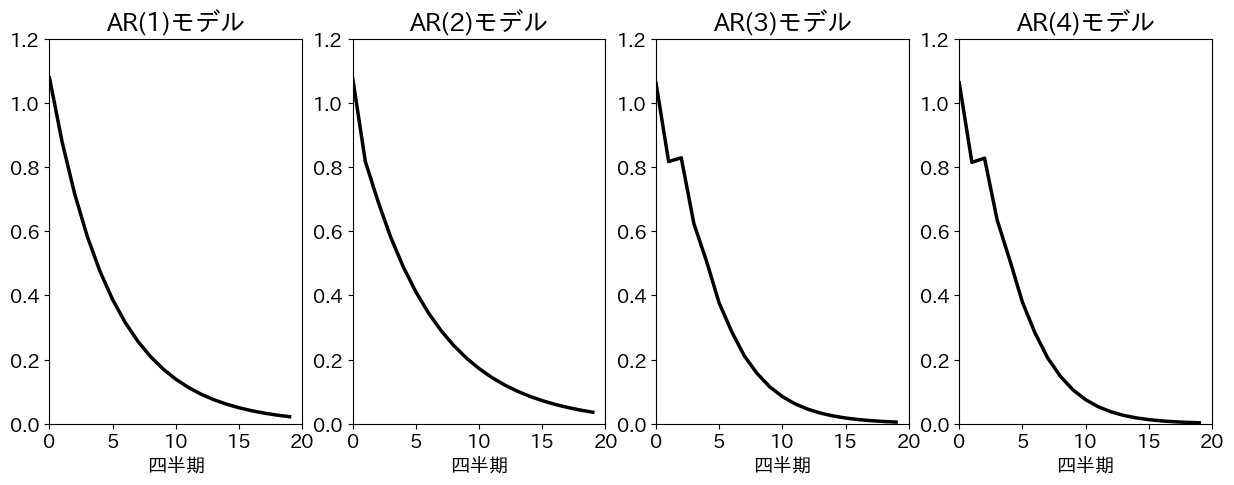

In [ ]:
# ARモデルの推定とインパルス応答関数
L = 4
MAX_H = 20
ssize = len(data)
plt.figure(figsize=(15, 5))
predict_result = np.zeros(MAX_H)
for l in range(1, L+1, 1):
    train_x, train_y = pd.DataFrame(), pd.DataFrame(data[L : ssize])
    for ll in range(1, l + 1):
        train_x_lagged = pd.DataFrame(
            data[L - ll : L - ll + len(train_y)].to_numpy()
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
    model = LinearRegression()
    model.fit(train_x, train_y)
    y_hat = model.predict(train_x)
    resid = np.std(y_hat - train_y)
    predict_result[0] = resid
    test_x = pd.DataFrame(pd.concat([resid,
                                     pd.DataFrame([np.zeros(l)])],
                                    axis=1).to_numpy())
    test_x = test_x.iloc[:,:l]
    for h in range(1, MAX_H, 1):
        forecast = pd.DataFrame([np.sum((test_x * model.coef_).to_numpy())])
        test_x = pd.concat([forecast,
                            pd.DataFrame((test_x.T[:-1]).T.to_numpy())],
                           axis=1)
        predict_result[h] = np.squeeze(np.array(forecast))
    ar_impulse = pd.DataFrame(predict_result).to_numpy()
    param_y = train_y
    param_x = sm.add_constant(train_x)
    param_model = sm.OLS(param_y.to_numpy(), param_x.to_numpy())
    param_result = param_model.fit()
    print('AR(%i)モデルの誤差項の標準偏差 \n' %l, resid.to_numpy())
    print(param_result.summary())
    # グラフの描画
    plt.subplot(1, 4, l)
    plt.plot(ar_impulse, linestyle='solid', color='black', linewidth=2.5)
    plt.title('AR(%i)モデル' %l, fontsize=18)
    plt.xlabel('四半期', fontsize=14)
    plt.tick_params(labelsize=14)
    plt.xticks(np.arange(0, MAX_H + 1, 5))
    plt.xlim(0, MAX_H)
    plt.ylim(0, 1.2)

ARモデルのラグ次数を選択するにあたり、最大ラグ次数を4としてAICとBICを計算すると、AICではラグ次数は1または3、BICではラグ次数は1が選択される

In [ ]:
# ARモデルのラグ次数の選択
def get_aic_bic(gap, y, y_hat, param1, param2):
    sse = ((y - y_hat) ** 2).sum(axis=0)
    aic = math.log(sse / (len(gap) - param1)) + (l + 1) * 2 / (len(gap) - param2)
    bic = math.log(sse / (len(gap) - param1)) + (l + 1) * math.log(
        (len(gap) - param2)
    ) / (len(gap) - param2)
    return aic, bic


MAX_L = 4
aic_result, bic_result = np.zeros([MAX_L + 1, 3]), np.zeros([MAX_L + 1, 3])
# AR(0)モデルの場合
l = 0
# AIC・BICの計算方法1:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合
y = pd.DataFrame(data[MAX_L:])
aic_result[l, 0], bic_result[l, 0] = get_aic_bic(data, y, np.mean(y.to_numpy()),
                                                 MAX_L, MAX_L)
# AIC・BICの計算方法2:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合（標本分散の自由度を調整）
y = pd.DataFrame(data[MAX_L:])
aic_result[l, 1], bic_result[l, 1] = get_aic_bic(
    data, y, np.mean(y.to_numpy()), MAX_L + l + 1, MAX_L
)
# AIC・BICの計算方法3:それぞれのARモデルで利用できる観測値をすべて利用した場合
y = pd.DataFrame(data[l:])
aic_result[l, 2], bic_result[l, 2] = get_aic_bic(data, y, np.mean(y.to_numpy()),
                                                 l, l)

# AR(p)モデル（p>0）の場合
for l in range(1, MAX_L + 1):
    # AIC・BICの計算方法1:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合
    x, y = pd.DataFrame(), pd.DataFrame(data[MAX_L:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(data[MAX_L - ll : MAX_L - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 0], bic_result[l, 0] = get_aic_bic(data, y, model.predict(x),
                                                     MAX_L, MAX_L)

    # AIC・BICの計算方法2:推定するすべてのARモデルのサンプルサイズが同じになるよう調整した場合（誤差項の標本分散の自由度を調整）
    x, y = pd.DataFrame(), pd.DataFrame(data[MAX_L:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(data[MAX_L - ll : MAX_L - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 1], bic_result[l, 1] = get_aic_bic(
        data, y, model.predict(x), MAX_L + l + 1, MAX_L
    )

    # AIC・BICの計算方法3:それぞれのARモデルで利用できる観測値をすべて利用した場合
    x, y = pd.DataFrame(), pd.DataFrame(data[l:])
    for ll in range(1, l + 1):
        x_lagged = pd.DataFrame(data[l - ll : l - ll + len(y)].to_numpy())
        x = pd.concat([x, x_lagged], axis=1)
    model = LinearRegression()
    model.fit(x, y)
    aic_result[l, 2], bic_result[l, 2] = get_aic_bic(data, y, model.predict(x),
                                                     l, l)

# 結果表の作成
df_aic_result = pd.DataFrame(
    aic_result,
    columns=[f'方法{i+1}' for i in range(3)],
    index=[f'L={i}' for i in range(MAX_L + 1)],
)
df_bic_result = pd.DataFrame(
    bic_result,
    columns=[f'方法{i+1}' for i in range(3)],
    index=[f'L={i}' for i in range(MAX_L + 1)],
)
print('[AIC]\n', df_aic_result)
print('[BIC]\n', df_bic_result)
print('[best AIC lag length]\n', df_aic_result.idxmin())
print('[best BIC lag length]\n', df_bic_result.idxmin())

[AIC]
           方法1       方法2       方法3
L=0  1.256197  1.262028  1.237300
L=1  0.174066  0.185762  0.174671
L=2  0.181063  0.198659  0.177995
L=3  0.167256  0.190786  0.168849
L=4  0.178653  0.208154  0.178653
[BIC]
           方法1       方法2       方法3
L=0  1.274497  1.280328  1.255314
L=1  0.210664  0.222360  0.210840
L=2  0.235962  0.253557  0.232461
L=3  0.240453  0.263984  0.241757
L=4  0.270150  0.299651  0.270150
[best AIC lag length]
 方法1    L=3
方法2    L=1
方法3    L=3
dtype: object
[best BIC lag length]
 方法1    L=1
方法2    L=1
方法3    L=1
dtype: object
